<a href="https://colab.research.google.com/github/iris-kurapaty/PytorchLightning_Experiments/blob/main/ERA_Assignment_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/ERA V1/Assignment 10/src'

Mounted at /content/drive
/content/drive/My Drive/ERA V1/Assignment 10/src


In [4]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 11.4 MB/s eta

In [5]:
!pip install torch-lr-finder


In [6]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 13.8 MB/s eta 0:00:00


In [7]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=2fa908ccfbf94ce15818a92f4e90bad41f46868d03cbb3fe2ac03f1653256c77
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
%cd 'drive/My Drive/ERA V1/Assignment 10/src'

[Errno 2] No such file or directory: 'drive/My Drive/ERA V1/Assignment 10/src'
/content/drive/My Drive/ERA V1/Assignment 10/src


In [8]:
from __future__ import print_function
from pytorch_lightning import LightningModule, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import *
from utils import *
from dataset import cifar10Dataset, get_loader
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torch_lr_finder import LRFinder
import gradio as gr
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [9]:
## Initializing some parameters
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

1

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.65E-02


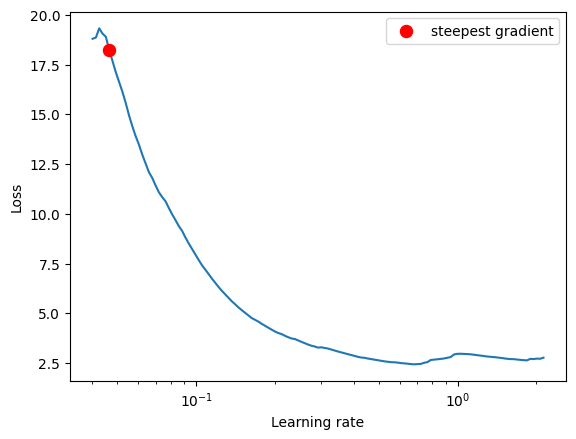

In [16]:
model = LitNet(0.1)
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

train_set = cifar10Dataset(root = "./data", train=True, transform=model.train_transform)
# train dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

lr_finder2 = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [ ]:
## Try without 16 precision and check for accuracy?

In [17]:
model = LitNet(4.65E-02)
trainer = Trainer(
    # precision = 16,
    # gpus = AVAIL_GPUS,
    max_epochs = 25,
)
trainer.fit(model)
trainer.test()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | criterion  | CrossEntropyLoss   | 0     
1 | accuracy   | MulticlassAccuracy | 0     
2 | prep_layer | Sequential         | 1.9 K 
3 | layer_1    | CustomBlock        | 369 K 
4 | layer_2    | Sequential         | 295 K 
5 | layer_3    | CustomBlock        | 5.9 M 
6 | max_pool   | Sequential         | 0     
7 | fc         | Linear             | 5.1 K 
--------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/ERA V1/Assignment 10/src/lightning_logs/version_15/checkpoints/epoch=24-step=4400.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/ERA V1/Assignment 10/src/lightning_logs/version_15/checkpoints/epoch=24-step=4400.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8030999898910522     │
│         val_loss          │    0.5908321142196655     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5908321142196655, 'val_acc': 0.8030999898910522}]

In [19]:
## Saving the Model
trainer.save_checkpoint('model.pth')

In [10]:
model = LitNet(4.65E-02)
model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')), strict = False)

_IncompatibleKeys(missing_keys=['prep_layer.0.weight', 'prep_layer.1.weight', 'prep_layer.1.bias', 'prep_layer.1.running_mean', 'prep_layer.1.running_var', 'layer_1.inner_layer.0.weight', 'layer_1.inner_layer.2.weight', 'layer_1.inner_layer.2.bias', 'layer_1.inner_layer.2.running_mean', 'layer_1.inner_layer.2.running_var', 'layer_1.res_block.conv1.weight', 'layer_1.res_block.bn1.weight', 'layer_1.res_block.bn1.bias', 'layer_1.res_block.bn1.running_mean', 'layer_1.res_block.bn1.running_var', 'layer_1.res_block.conv2.weight', 'layer_1.res_block.bn2.weight', 'layer_1.res_block.bn2.bias', 'layer_1.res_block.bn2.running_mean', 'layer_1.res_block.bn2.running_var', 'layer_2.0.weight', 'layer_2.2.weight', 'layer_2.2.bias', 'layer_2.2.running_mean', 'layer_2.2.running_var', 'layer_3.inner_layer.0.weight', 'layer_3.inner_layer.2.weight', 'layer_3.inner_layer.2.bias', 'layer_3.inner_layer.2.running_mean', 'layer_3.inner_layer.2.running_var', 'layer_3.res_block.conv1.weight', 'layer_3.res_block.bn

In [11]:
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
test_data = cifar10Dataset(root = "./data", train=False, transform=model.test_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)
incorrect_examples, incorrect_labels,incorrect_pred = mis_classified_images(model, device, test_loader)

Files already downloaded and verified


In [22]:
def inference(grad_cam_flag, grad_num, input_img, num_class, transparency, target_num_layer, misclass_flag, misclass_num):
  grad_cam_images = []
  grad_cam_output = []
  missclassified_output = []

  if misclass_flag:
    missclassified_output = incorrect_examples[0][:misclass_num]
    missclassified_output = [inv_normalize(torch.from_numpy(missclassified_output[i])) for i in range(misclass_num)]
    missclassified_output = [np.transpose(missclassified_output[i], (1, 2, 0)) for i in range(misclass_num)]
    missclassified_output = [missclassified_output[i].numpy() for i in range(misclass_num)]

  if grad_cam_flag:
    transform = transforms.ToTensor()
    org_img = input_img
    input_img = transform(input_img)
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    softmax = torch.nn.Softmax(dim=0)
    o = softmax(outputs.flatten())
    confidences = {classes[i]: float(o[i]) for i in range(10)}
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.layer_2[target_num_layer]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    grad_cam_output = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    # grad_cam_output.append(grad_cam_)

  if grad_cam_flag & grad_num>0:
    grad_cam_images = display_gradcam(model, incorrect_examples, grad_num, inv_normalize, 0.8)

  confidences = dict(sorted(confidences.items(), key=lambda x:x[1], reverse=True))
  top_class = list(confidences.items())[:num_class]
  top_class = dict(top_class)

  return top_class, grad_cam_images, grad_cam_output, missclassified_output

demo = gr.Interface(
    inference,
    inputs = [
        gr.Checkbox(label = 'Would you like to see GradCam images?'),
        gr.Slider(0,20, step=5, value= 3, label='If yes, how many GradCam Images'),
        gr.Image(shape=(32,32), label='Input Image to check GradCAM'),
        gr.Slider(1,10, step=1, value= 0, label='How many top classes would you like to see?'),
        gr.Slider(0,1, value= 0.5, label='Overlap Opacity of Image'),
        gr.Slider(-2,-1, value= -1, label='Which layer?'),
        gr.Checkbox(label = 'Would you like to see Missclassfied images?'),
        gr.Slider(1,10, step=1, value= 0, label='How many Missclassified images would you like to see?')
    ],
    outputs = [
        "label",
        gr.Gallery(label='GradCam images').style(width=128, height=128),
        gr.Image(shape=(32,32)).style(width=128, height=128),
        gr.Gallery(label='Missclassified Images').style(width=128, height=128)

    ],
    title = 'Displaying Grad Cam and MissClassified Images',
    description = 'Pick the following options to decide on outputs'
    # examples = [["dog.jpg", 0.7, -1],["deer.jpg", 0.8, -1]]
)
demo.launch()

<ipython-input-22-9c1e94109a0a>:57: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Gallery(label='GradCam images').style(width=128, height=128),
<ipython-input-22-9c1e94109a0a>:58: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Image(shape=(32,32)).style(width=128, height=128),
<ipython-input-22-9c1e94109a0a>:59: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Gallery(label='Missclassified Images').style(width=128, height=128)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>